# Import Libraries and Load data

In [16]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

from python_speech_features import mfcc

root = './musicnet'

%matplotlib inline

In [17]:
# Check the cuda version and if it is available
print(torch.version.cuda)  
print(torch.cuda.device_count())
print(torch.cuda.is_available())

10.1
1
True


This code for loading the data come from : https://github.com/jthickstun/pytorch_musicnet/blob/master/musicnet_module.ipynb

In [18]:
def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 0, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 500
d = 4096

window = 16384
stride = 512
regions = 1 + (window - d)//stride

In [19]:
train_set = musicnet.MusicNet(root=root, train=True, download=False, window=window)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

# Define the models

In [21]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    return wsin,wcos

In [22]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand([regions*k,m]).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    # print(x.shape)
    # print(beta.shape)
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # Adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

## Extracting MFCC features 

use of python_speech_features packages it uses interval tree in order to tag the frame. "This library was designed to allow tagging text and time intervals, where the intervals include the lower bound but not the upper bound."


In [23]:
with train_set, test_set:
    for i, (x, y) in enumerate(train_loader):
        
        print('shape of x : ',x[10].shape)
        
        print('shape of y : ',y.shape)
        
        mfcc_feat = mfcc(x.numpy()[10],samplerate =16384)
        
        print('mfcc feat : ' , mfcc_feat)
        
        print('shape of the mfcc feat : ', mfcc_feat.shape)
        print("the shape of the mfcc correspond to the number of ceptrum : 13 by the number of frame : 99")
        break

shape of x :  torch.Size([16384])
shape of y :  torch.Size([100, 128])
mfcc feat :  [[ -9.86788653  22.86974027  -7.85942851 ...   4.67228528   0.30204129
    2.49686355]
 [ -9.6452785   48.96314964 -38.56841723 ...  -5.03651675   6.10907733
   -2.28633738]
 [ -9.41687527  27.46877512 -13.53275395 ...   2.4575895   -4.46476336
    4.5250633 ]
 ...
 [ -9.66808042  31.99874182 -10.03742397 ...  -3.14302326  -2.32464771
    3.53607105]
 [ -9.70595975  39.82210548 -17.29423434 ...  -3.77651141   1.2792643
    0.63753191]
 [-10.0888572   30.06405828  -8.24369748 ...   2.77802416   3.64735744
    2.06678688]]
shape of the mfcc feat :  (99, 13)
the shape of the mfcc correspond to the number of ceptrum : 13 by the number of frame : 99


x : 100 : number of frame ? 16384 frame rate ?

y : 100 : number of frame, 128 dimension of the possible sound

## Creation of the model

In [24]:
x

tensor([[ 5.3128e-04,  4.6951e-04,  4.4479e-04,  ..., -9.5013e-03,
         -1.2479e-02, -1.5481e-02],
        [ 5.4795e-05, -1.2786e-03, -2.6484e-03,  ..., -5.4795e-03,
         -6.1736e-03, -6.7398e-03],
        [-4.5612e-03, -4.2656e-03, -4.0755e-03,  ..., -6.1344e-03,
         -5.7226e-03, -5.1842e-03],
        ...,
        [-4.8731e-03, -5.0050e-03, -5.1434e-03,  ...,  1.0241e-02,
          9.2120e-03,  8.2229e-03],
        [-3.2729e-03, -1.2381e-03,  9.3366e-04,  ..., -3.4099e-03,
         -2.5726e-03, -1.8369e-03],
        [-8.7607e-04, -1.9463e-03, -2.9714e-03,  ..., -4.5452e-03,
         -3.8565e-03, -3.1882e-03]])

# Plot MFCC and spectogramm

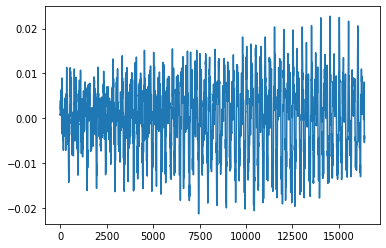

In [25]:
plt.plot(x.numpy()[10])
plt.show()

In [26]:
import pretty_midi
import librosa, librosa.display

C:\Users\Samue\Anaconda3\envs\BML\lib\site-packages\librosa\core\spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


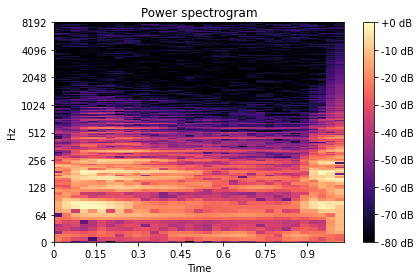

In [27]:
D = librosa.stft(x.numpy()[0])
sr = 16384
librosa.display.specshow(librosa.amplitude_to_db(D,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

## Define the model

## Use the model

In [28]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [29]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        # Define the header 
        print('square loss\tavg prec\ttime\t\tutime')
        # Start running the different epochs
        for epoch in range(2):
            t = time()
            
            for i, (x, y) in enumerate(train_loader):
                # 
                optimizer.zero_grad()
                
                ## Transform x and y into cuda variable
                x = Variable(x.cuda(), requires_grad=False)
                y = Variable(y.cuda(), requires_grad=False)
                
                ## Compute the loss
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.data.copy_(avg*wavg.data + (1.-avg)*w.data)
                    
            # Begin to count how many time the epochs last
            t1 = time()
            
            # Begin the test on the test set
            
            ## Initialize the loss and the average precision score
            avgp = 0.
            loss = 0.
            
            ## Initialize the table where we will put the rediction and the actual value
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            for i, (x, y) in enumerate(test_loader):
                
                ## Transform x and y into cuda variable
                x,y  = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                
                ## Compute the prediction
                yhatvar = forward(x,*averages)
                
                ## Compute the loss
                loss += L(yhatvar,y,*averages).item()
                
                ## Save the truth
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                
                ## Save the prediction
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
                
            ## Compute the average precision score
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            
            ## Save the data into table
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            
            ## Print the results after each epoch
            print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

square loss	avg prec	time		utime
0.980719	0.616759	1265.512738	95.788757
0.874054	0.634574	1181.261800	92.088164
Finished


In [49]:
loss_history

[0.9807189586162567, 0.8740540376901627]

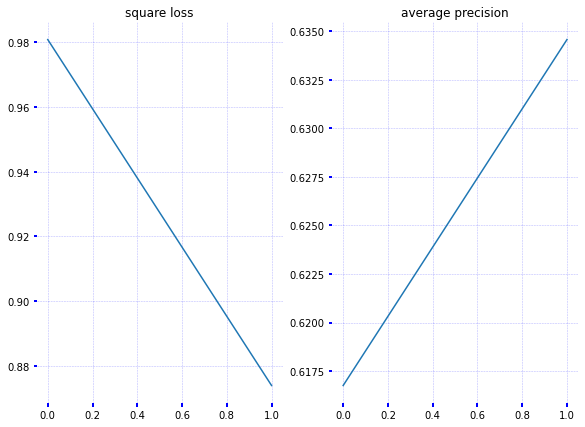

In [50]:
burnin = 0

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')

ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])

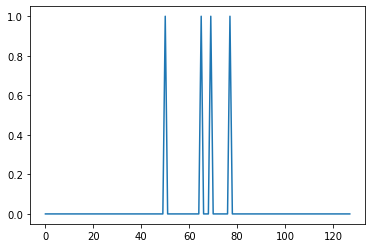

In [48]:
plt.plot(y.detach().cpu()[50])

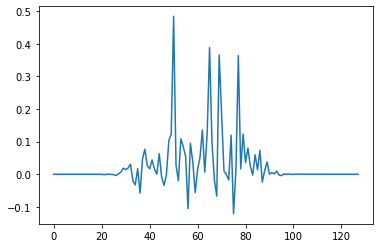

In [47]:
plt.plot(forward(x,*weights).cpu().detach().numpy()[50])